In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from qrisp.operators import X, Y, Z
from qrisp.vqe.problems.heisenberg import *
import networkx as nx

import pickle
from time import time
from datetime import datetime

def save_data(data, filename):  
    # Open a file for writing
    with open(filename+'.pickle', 'wb') as file:
        # Write the object to the file
        pickle.dump(data, file)

def load_data(filename):
    with open(filename+'.pickle', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
    return data

In [2]:
L = 10
G = nx.Graph()
G.add_edges_from([(k,(k+1)%L) for k in range(L-1)]) 

J = 1
B = 0.5
H = create_heisenberg_hamiltonian(G, J, B)

H_matrix = H.to_array()
eigvals, eigvecs = np.linalg.eigh(H_matrix)
idx = np.argsort(eigvals)
eigvals_sorted = eigvals[idx].real
print('Eigen energies:', eigvals_sorted)
eigvecs_sorted = eigvecs[:,idx].T
eigvecs_sorted = [vec.reshape(-1,1) for vec in eigvecs_sorted]


Eigen energies: [-17.03214083 -16.72269436 -15.72269436 ...  12.80422607  13.
  14.        ]


In [4]:
results = load_data('data/benchmarks_2nd_B=0.5_03-20-18')
#results = load_data('data/benchmarks_2nd_B=1_03-20-20')

In [5]:
def run_param_rc(fontsize = 30):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = "serif"
        plt.rcParams['font.serif'] = "cm"

run_param_rc(18)

# QITE with Singlet and VQE warm start

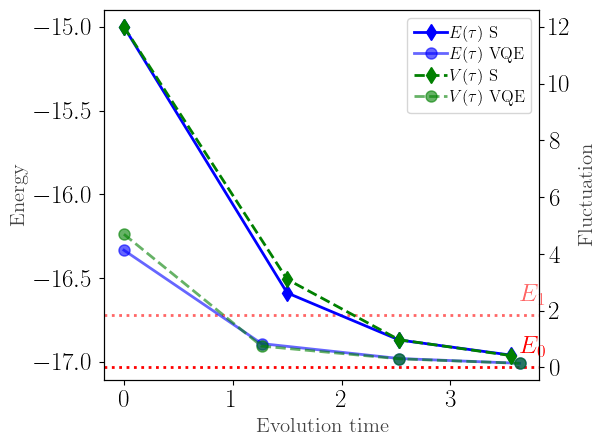

In [6]:

lables_energies=["$E(\\tau)$ S","$E(\\tau)$ S","$E(\\tau)$ VQE","$E(\\tau)$ VQE"]
lables_fluctuations=["$V(\\tau)$ S","$V(\\tau)$ S","$V(\\tau)$ VQE","$V(\\tau)$ VQE"]

alphas = [1.0, 0.6]
markers = ['d','o']

fig, ax1 = plt.subplots()

#indices = [0,2] # GC
indices = [1,3] # HOPF

beta_max = np.max([np.max(results[i]['evolution_times']) for i in indices])

# 1) Plot energies on the left y-axis
for i,ind in enumerate(indices):
    line1, = ax1.plot(results[ind]['evolution_times'], results[ind]['optimal_energies'], label=lables_energies[ind], color='blue', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=alphas[i])

ax1.axhline(y=eigvals_sorted[0], color="red", linestyle=':')
ax1.axhline(y=eigvals_sorted[1], color="red", linestyle=':', alpha = 0.6)

ax1.text(
    beta_max,           # shift text slightly to the right
    eigvals_sorted[0]+0.12,             # same y as the line
    r"$E_0$",                           # label for that line
    va="center",
    ha="left",
    color="red",
)
ax1.text(
    beta_max,           # shift text slightly to the right
    eigvals_sorted[1]+0.12,             # same y as the line
    r"$E_1$",                           # label for that line
    va="center",
    ha="left",
    color="red",
    alpha = 0.6
)

ax1.set_xlabel("Evolution time", fontsize=15, color='#444444')
ax1.set_ylabel("Energy", fontsize=15, color='#444444')

# 2) Create a twin axis for fluctuations
ax2 = ax1.twinx()
for i,ind in enumerate(indices):
    line2, = ax2.plot(results[ind]['evolution_times'], results[ind]['variances'], label=lables_fluctuations[ind], color='green', marker=markers[i], linestyle='dashed', linewidth=2, zorder=3, alpha=alphas[i])
ax2.set_ylabel("Fluctuation", fontsize=15, color='#444444')

# 3) Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

#plt.grid()
plt.tight_layout()
#plt.savefig("plots/QITE_rescaled_2nd_B=0.5_GC.pdf")
#plt.savefig("plots/QITE_rescaled_2nd_B=0.5_HOPF.pdf")
plt.show()

In [8]:
psi = eigvecs_sorted[0]

states = results[0]["statevectors"]

fidelities = []
for phi in states:
    fidelities.append(np.abs(np.dot(psi.transpose()[0],phi))**2)

fidelities

[np.float64(0.6826140203303995),
 np.float64(0.89965516888205),
 np.float64(0.9540818122756572),
 np.float64(0.9771189073381689),
 np.float64(0.9881538608901776),
 np.float64(0.9938565461193895)]

In [9]:
psi = eigvecs_sorted[0]

states = results[1]["statevectors"]

fidelities = []
for phi in states:
    fidelities.append(np.abs(np.dot(psi.transpose()[0],phi))**2)

fidelities

[np.float64(0.6826140203303995),
 np.float64(0.9098086785316326),
 np.float64(0.9613087698190976),
 np.float64(0.982150450698757)]

In [54]:
results[1]["circuit_data"]

[{0: {'u3': 10, 'cx': 5},
  1: {'u3': 866, 'cx': 529},
  2: {'u3': 5106, 'cx': 3181},
  3: {'u3': 26156, 'cx': 16381}},
 {0: 10, 1: 19, 2: 19, 3: 19},
 {0: 2, 1: 277, 2: 1627, 3: 8377},
 {0: 10, 1: 19, 2: 19, 3: 19}]

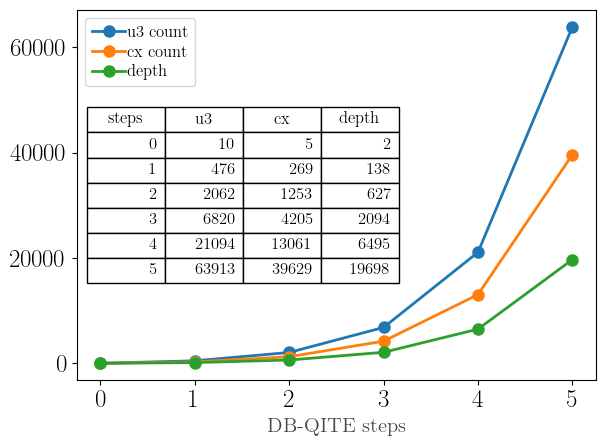

In [52]:
steps = [0,1,2,3,4,5]
u_count = [results[0]["circuit_data"][0][k]['u3'] for k in steps]
cx_count = [results[0]["circuit_data"][0][k]['cx'] for k in steps]
depth = [results[0]["circuit_data"][2][k] for k in steps]

fig, ax = plt.subplots()

ax.plot(steps, u_count, marker='o', label='u3 count')
ax.plot(steps, cx_count, marker='o', label='cx count')
ax.plot(steps, depth, marker='o', label='depth')

ax.set_xlabel("DB-QITE steps", fontsize = 15, color='#444444')
ax.set_ylabel("", fontsize = 15, color='#444444')

# Data for the table
rows = [' 0 ', '1', '2', '3', '4','5']
columns = ('steps','u3', 'cx', 'depth')
cell_text = [[rows[i], u_count[i], cx_count[i], depth[i]] for i in range(6)]

# Adjust column widths
col_widths = [0.1, 0.1, 0.1, 0.1]  # First column is wider

# Add a table at the bottom of the axes
table = ax.table(cellText=cell_text,
                     colLabels=columns,
                     loc='center left',
                     colWidths=col_widths)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)  # Adjust the scaling as needed

plt.legend(loc="best")

plt.tight_layout()
plt.savefig('plots/circuit_data.pdf')
plt.show()